In [1]:
import networkx as nx 
import random
import matplotlib.pyplot as plt
import numpy as np
import math

In [2]:
# Common neighbours
def CN(x,y,graph):
    s = 0
    for i in graph.neighbors(x):
        for j in graph.neighbors(y):
            if i == j:
                s += 1
    return s

In [3]:
# source : https://stackoverflow.com/questions/15590812/networkx-convert-multigraph-into-simple-graph-with-weighted-edges
def multi_to_weighted(graph): 
    
    # we create the graph with all the nodes from the original dataset
    G = nx.Graph()
    G.add_nodes_from(graph.nodes())
    
    for u,v,data in graph.edges(data=True):
        w = data['weight'] if 'weight' in data else 1.0
        if G.has_edge(u,v):
            G[u][v]['weight'] += w
        else:
            G.add_edge(u, v, weight=w)
        
    return G

In [4]:
def features_directed(graph, actual_edges, multi = False):
      
    n = graph.number_of_nodes()
    nodes = list(graph.nodes)
    in_deg = list(graph.in_degree)
    out_deg = list(graph.out_degree)
    # Clustering function does not work for multigraphs
    if multi == True: 
        G = multi_to_weighted(graph)
        CC = nx.clustering(G)
    else:CC = nx.clustering(graph)
    
    data0_X_train = []
    data0_Y_train = []
    data0_nodes_train = []
    X_train, Y_train = [],[]
    X_test, Y_test, nodes_test = [],[],[]
    
    for i in range(n):
        neighbors = [n for n in graph.neighbors(nodes[i])] # list of the neighbors of node i
        for j in range(n):
            if i != j :
                
                if nodes[j] in neighbors: 
                    features = []
                    # there is a link between the nodes in the graph
                    # the training set is composed of all the present edges of the graph
                    
                    Y_train.append(1)
                    features.append(in_deg[i][1])
                    features.append(in_deg[j][1])
                    features.append(out_deg[i][1])
                    features.append(out_deg[j][1])
                    features.append(CC[nodes[i]])
                    features.append(CC[nodes[j]])
                    features.append(CN(nodes[i],nodes[j],graph))
                    X_train.append(features)
                
                if (multi==False and nodes[j] not in neighbors) or (multi==True): 
                    features = []
                    # there is no link between the nodes in the graph, if it is not a multigraph
                    
                    if [nodes[i],nodes[j]] not in actual_edges: 
                        # this is not one of the removed edges
                        data0_nodes_train.append([nodes[i],nodes[j]])
                        data0_Y_train.append(0)
                        features.append(in_deg[i][1])
                        features.append(in_deg[j][1])
                        features.append(out_deg[i][1])
                        features.append(out_deg[j][1])
                        features.append(CC[nodes[i]])
                        features.append(CC[nodes[j]])
                        features.append(CN(nodes[i],nodes[j],graph))
                        data0_X_train.append(features)
                    else: # the testing set is composed of all the present edges previously removed
                        nodes_test.append([nodes[i],nodes[j]])
                        Y_test.append(1)
                        features.append(in_deg[i][1])
                        features.append(in_deg[j][1])
                        features.append(out_deg[i][1])
                        features.append(out_deg[j][1])
                        features.append(CC[nodes[i]])
                        features.append(CC[nodes[j]])
                        features.append(CN(nodes[i],nodes[j],graph))
                        X_test.append(features)

    l = int(len(data0_Y_train)/5) # the number of absent edges in the graph to remove
   
    # We shuffle the data of absence of edges in the same way 
    data0 = list(zip(data0_nodes_train, data0_Y_train, data0_X_train))
    random.shuffle(data0)
    data0_nodes_train, data0_Y_train, data0_X_train = zip(*data0)
    
    # We randomly remove 1/5 of the absent edges of the graph
    X_train += data0_X_train[l:]
    Y_train += data0_Y_train[l:]
    
    # We randomly add the 1/5 to the pairs of nodes to predict
    X_test += data0_X_train[:l]
    Y_test += data0_Y_train[:l]
    nodes_test += data0_nodes_train[:l]
    
    return X_train, Y_train, X_test, Y_test, nodes_test

In [5]:
def features_undirected(graph, actual_edges, multi = False):
      
    n = graph.number_of_nodes()
    nodes = list(graph.nodes)
    edges = list(graph.edges)
    deg = list(graph.degree)
    # Clustering function does not work for multigraphs
    if multi == True: 
        G = multi_to_weighted(graph)
        CC = nx.clustering(G)
    else:CC = nx.clustering(graph)
    
    data0_X_train = []
    data0_Y_train = []
    data0_nodes_train = []
    X_train, Y_train = [],[]
    X_test, Y_test, nodes_test = [],[],[]

    for i in range(n):
        neighbors = [n for n in graph.neighbors(nodes[i])] # list of the neighbors of node i
        for j in range(i+1,n):
            if i != j :
                
                if nodes[j] in neighbors: 
                    features = []
                    # there is a link between the nodes in the graph
                    # the training set is composed of all the present edges of the graph
                    
                    Y_train.append(1)
                    features.append(deg[i][1]+deg[j][1])
                    features.append(max(deg[i][1],deg[j][1])-min(deg[i][1],deg[j][1]))
                    features.append(CC[nodes[i]]+CC[nodes[j]])
                    features.append(max(CC[nodes[i]],CC[nodes[j]])-min(CC[nodes[i]],CC[nodes[j]]))
                    features.append(CN(nodes[i],nodes[j],graph))
                    X_train.append(features)
                
                if (multi==False and nodes[j] not in neighbors) or (multi==True): 
                    features = []
                    # there is no link between the nodes in the graph, if it is not a multigraph
                    
                    # Notation: the nodes of minimum number first                             
                    if [min(nodes[i],nodes[j]),max(nodes[i],nodes[j])] not in actual_edges: 
                        # this is not one of the removed edges
                        data0_nodes_train.append([min(nodes[i],nodes[j]),max(nodes[i],nodes[j])])
                        data0_Y_train.append(0)
                        features.append(deg[i][1]+deg[j][1])
                        features.append(max(deg[i][1],deg[j][1])-min(deg[i][1],deg[j][1]))
                        features.append(CC[nodes[i]]+CC[nodes[j]])
                        features.append(max(CC[nodes[i]],CC[nodes[j]])-min(CC[nodes[i]],CC[nodes[j]]))
                        features.append(CN(nodes[i],nodes[j],graph))
                        data0_X_train.append(features)
                    else: # the testing set is composed of all the present edges previously removed
                        nodes_test.append([min(nodes[i],nodes[j]),max(nodes[i],nodes[j])])
                        Y_test.append(1)
                        features.append(deg[i][1]+deg[j][1])
                        features.append(max(deg[i][1],deg[j][1])-min(deg[i][1],deg[j][1]))
                        features.append(CC[nodes[i]]+CC[nodes[j]])
                        features.append(max(CC[nodes[i]],CC[nodes[j]])-min(CC[nodes[i]],CC[nodes[j]]))
                        features.append(CN(nodes[i],nodes[j],graph))
                        X_test.append(features)         
                

    l = int(len(data0_Y_train)/5) # the number of absent edges in the graph to remove

    # We shuffle the data of absence of edges in the same way 
    data0 = list(zip(data0_nodes_train, data0_Y_train, data0_X_train))
    random.shuffle(data0)
    data0_nodes_train, data0_Y_train, data0_X_train = zip(*data0)
    
    # We randomly remove 1/5 of the absent edges of the graph
    X_train += data0_X_train[l:]
    Y_train += data0_Y_train[l:]
    
    # We randomly add the 1/5 to the pairs of nodes to predict
    X_test += data0_X_train[:l]
    Y_test += data0_Y_train[:l]
    nodes_test += data0_nodes_train[:l]
    
    return X_train, Y_train, X_test, Y_test, nodes_test

Implementation of the Gaussian Naive Bayes method thanks to: https://machinelearningmastery.com/naive-bayes-classifier-scratch-python/ 

In [6]:
def separate_by_class(X_train,Y_train):
    separated = {}
    prob_class = {}
    N = len(X_train)
    for i in range(len(X_train)):
        if (Y_train[i] not in separated):
            separated[Y_train[i]] = []
            prob_class[Y_train[i]] = 0
        separated[Y_train[i]].append(X_train[i])
        prob_class[Y_train[i]] += 1/N
    return separated, prob_class

In [7]:
def mean(vector):
    return sum(vector)/float(len(vector))

In [8]:
def std(vector):
    m = mean(vector)
    v = sum([(x-m)**2 for x in vector])/float(len(vector)-1)
    return v**0.5

In [9]:
def summarize_by_class(X_train,Y_train):
    separated,prob_class = separate_by_class(X_train,Y_train)
    summaries = {}
    for classValue, instances in separated.items():
        summaries[classValue] = [(mean(attribute), std(attribute)) for attribute in zip(*instances)]
    return summaries,prob_class

In [10]:
def GaussianProbability(x, mean, std):
    exponent = math.exp(-(math.pow(x-mean,2)/(2*math.pow(std,2))))
    return (1 / (math.sqrt(2*math.pi) * std)) * exponent

In [11]:
def ClassProbabilities(summaries, prob_class, x):
    
    probabilities = {}
    
    for classValue, classSummaries in summaries.items():
        probabilities[classValue] = prob_class[classValue]
    
        for i in range(len(classSummaries)):  # for every attribute
            mean, std = classSummaries[i]
            probabilities[classValue] *= GaussianProbability(x[i], mean, std)
            
    return probabilities

In [12]:
def prediction(graph, actual_edges, network_type='undirected', multi = False):
    
    if network_type == 'directed':
        X_train, Y_train, X_test, Y_test, nodes_test = features_directed(graph, actual_edges, multi)
    else: 
        X_train, Y_train, X_test, Y_test, nodes_test = features_undirected(graph, actual_edges, multi)

    summaries,prob_class = summarize_by_class(X_train,Y_train)
    links = []
    probabilities_0 = []
    
    for i in range(len(X_test)):  
        prob = ClassProbabilities(summaries, prob_class, X_test[i])
        if (prob[0]+prob[1])==0:
            # both probabilities are too low
            # we prefer to not predict anything 
            probabilities_0.append(1) 
        else:probabilities_0.append(float(prob[0]/(prob[0]+prob[1])))
        links.append(nodes_test[i])
    
    Z = sorted(zip(list(probabilities_0),links))
    probabilities_0,links = zip(*Z)
    
    return list(probabilities_0),list(links)

In [13]:
# function giving all kind of results on performance

def results(probabilities_0, predictions, actual_edges, graph):
    
    n = graph.number_of_nodes()
    nodes = list(graph.nodes)
    n_edges = graph.number_of_edges()
    test_size = len(actual_edges)
    
    precisions = []
    recalls = []
    fp_rates = []
    MAP = 0
    tp = 0
    fp = 0
    tn = len(predictions)-test_size # when 0 positive is predicted
    fn = test_size # when 0 positive is predicted
    stop = False # become true once we reached the threshold limit of 0.5
    
    
    for k in range(len(predictions)):
        
        if probabilities_0[k]>0.5 and tp != 0 and stop == False:
            # We compute MAP for the threshold 0.5
            stop = True
            MAP = MAP / tp
            
        if predictions[k] in actual_edges:
            tp += 1
            fn -= 1  
            if probabilities_0[k]<=0.5:
                MAP += (tp /(tp + fp))   
        else:
            fp += 1
            tn -= 1

        if (tp != 0 or fp != 0) and probabilities_0[k]<=0.5:
            # average precision for probability of 0 <= 0.5
            # precision = tp /(tp + fp)
            precisions.append(tp/(tp + fp))
            
        if tp != 0 or fn != 0:
        # tp + fn = relevant_edges
            recalls.append(tp/(tp + fn))                 
        if tn != 0 or fp != 0:
            # tn + fp = num_vertices*(num_vertices-1) - num_edges - relevant_edges = irrelevant_edges
            fp_rates.append(fp/(tn + fp))
                
    if tp == 0:  # Not even one good prediction
        return [0]*test_size,0,[0]*(k+1),[0]*(k+1)
    
    return(precisions,MAP,recalls,fp_rates)

In [14]:
# Average results for the 5-CrossValidation

def CV_results(list_graphs, list_targets, network_type='undirected', multi = False):
    test_size = len(list_targets[0])
    precisions, MAP, recalls, fp_rates= [0]*test_size,0,[],[]
    
    for part in range(5):
        
        probabilities_0,predictions = prediction(list_graphs[part], list_targets[part], network_type, multi)
        
        if recalls == [] and fp_rates == []:
            recalls, fp_rates = [0]*len(predictions),[0]*len(predictions)
        precisions_N, MAP_N, recalls_N, fp_rates_N = results(probabilities_0,predictions,list_targets[part],list_graphs[part])
        precisions,MAP,recalls,fp_rates = [sum(x) for x in zip(precisions,precisions_N)] ,MAP+MAP_N, [sum(x) for x in zip(recalls,recalls_N)], [sum(x) for x in zip(fp_rates,fp_rates_N)]
  
    return([x/5 for x in precisions], MAP/5, [x/5 for x in recalls], [x/5 for x in fp_rates])

In [15]:
def AUROC(fp_rates,recalls):
    score = 0
    
    for x in range(1,len(fp_rates)):
        score += (fp_rates[x]-fp_rates[x-1])*recalls[x]
        
    return score

### First dataset: PROTEINS 

In [16]:
# Importation of the dataset: PROTEINS
# http://konect.uni-koblenz.de/networks/maayan-Stelzl 

PROT = []
with open('out.maayan-Stelzl') as inputfile:
    for line in inputfile:
        PROT.append(line.strip().split(','))
PROT = PROT[1:] # list of all the edges
random.shuffle(PROT) # we randomly shuffle the edges

# test size
num_edges_PROT = len(PROT)
num_vertices_PROT = 1706
test_size_PROT = int(num_edges_PROT/5)

# Contains the 5 parts forming the whole dataset
parts_PROT = []

start = 0
end = test_size_PROT
for part in range(5):  # We create the 5 parts
    if end>num_edges_PROT:
        parts_PROT.append(PROT[start:])
    else:parts_PROT.append(PROT[start:end])
    start = end
    end = start + test_size_PROT

In [17]:
PROT_G = nx.DiGraph()
for edge in range(len(PROT)):
    nodes = PROT[edge][0].split(' ')
    PROT_G.add_edge(int(nodes[0]), int(nodes[1])) 
PROT_nodes = PROT_G.nodes()

In [18]:
# graphs contains the 5 different training networks 
# targets contains the target links corresponding

PROT_graphs = []
PROT_targets = []

for i in range(5):     # i is the index of the folder we won't use
    G = nx.DiGraph()
    G.add_nodes_from(PROT_nodes)
    target_links = [] 
    for j in range(5): # We use every other folder
        data = parts_PROT[j]
        if j!=i:        
            for edge in range(len(data)):
                nodes = data[edge][0].split(' ')
                G.add_edge(int(nodes[0]), int(nodes[1])) 
                
                
        else:
            for edge in range(len(data)):
                nodes = data[edge][0].split(' ')
                target_links.append([int(nodes[0]),int(nodes[1])])
                
                

    PROT_graphs.append(G)
    PROT_targets.append(target_links)

In [19]:
precisions,MAP,recalls,fp_rates = CV_results(PROT_graphs,PROT_targets,'directed')

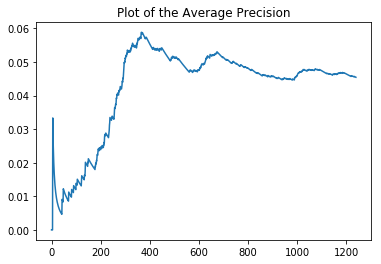

In [20]:
plt.figure()
X = [x for x in range(len(precisions))]
plt.plot(X,precisions)
plt.title('Plot of the Average Precision')
plt.show()

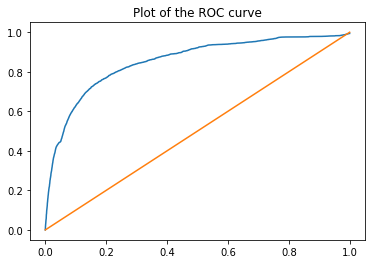

In [21]:
plt.figure()
plt.plot(fp_rates, recalls, fp_rates,fp_rates )
plt.title('Plot of the ROC curve')
plt.show()

In [22]:
AUROC(fp_rates, recalls)

0.8524810686495811

In [23]:
MAP

0.035891435039034955

### Second dataset: INFECTIOUS

In [24]:
# Importation of the dataset: INFECTIOUS
# http://konect.uni-koblenz.de/networks/sociopatterns-infectious 

INF = []
with open('sociopatterns-infectious\out.sociopatterns-infectious') as inputfile:
    for line in inputfile:
        INF.append(line.strip().split(','))
INF = INF[2:] # list of all the edges
random.shuffle(INF) # we randomly shuffle the edges

# test size
num_edges_INF = len(INF)
num_vertices_INF = 410
test_size_INF = int(num_edges_INF/5)

# Contains the 5 parts forming the whole dataset
parts_INF = []

start = 0
end = test_size_INF
for part in range(5):  # We create the 5 parts
    if end>num_edges_INF:
        parts_INF.append(INF[start:])
    else:parts_INF.append(INF[start:end])
    start = end
    end = start + test_size_INF

In [25]:
INF_G = nx.MultiGraph()
for edge in range(len(INF)):
    nodes = INF[edge][0].split(' ')
    INF_G.add_edge(int(nodes[0]), int(nodes[1])) 
INF_nodes = INF_G.nodes()

In [26]:
# graphs contains the 5 different training networks 
# targets contains the target links corresponding

INF_graphs = []
INF_targets = []

for i in range(5):     # i is the index of the folder we won't use
    G = nx.MultiGraph()
    G.add_nodes_from(INF_nodes)
    target_links = [] 
    for j in range(5): # We use every other folder
        data = parts_INF[j]
        if j!=i:        
            for edge in range(len(data)):
                nodes = data[edge][0].split(' ')
                G.add_edge(int(nodes[0]), int(nodes[1])) 
                
                
        else:
            for edge in range(len(data)):
                nodes = data[edge][0].split(' ')
                # For undirected network, we write the min node first
                # We don't want duplicates because we cannot predict the number of edges to add
                if [min(int(nodes[0]),int(nodes[1])),max(int(nodes[0]),int(nodes[1]))] not in target_links:
                    target_links.append([min(int(nodes[0]),int(nodes[1])),max(int(nodes[0]),int(nodes[1]))])
                
                
    INF_graphs.append(G)
    INF_targets.append(target_links)

In [27]:
precisions_INF, MAP_INF, recalls_INF, fp_rates_INF = CV_results(INF_graphs,INF_targets,'undirected',True)

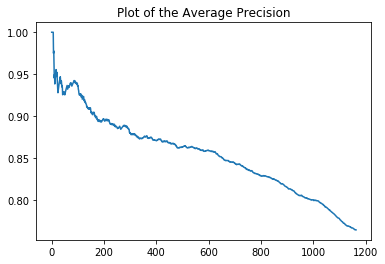

In [28]:
plt.figure()
X_INF = [x for x in range(len(precisions_INF))]
plt.plot(X_INF,precisions_INF)
plt.title('Plot of the Average Precision')
plt.show()

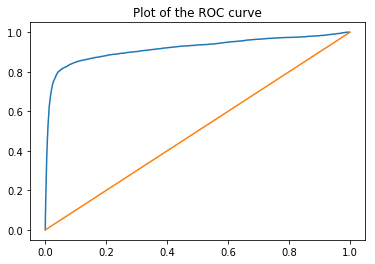

In [29]:
plt.figure()
plt.plot(fp_rates_INF, recalls_INF, fp_rates_INF,fp_rates_INF )
plt.title('Plot of the ROC curve')
plt.show()

In [30]:
AUROC(fp_rates_INF, recalls_INF)

0.9176840867569291

In [31]:
MAP_INF

0.86041345089972

### Third dataset: ADOLESCENT

In [32]:
# Importation of the dataset: ADOLESCENT
# http://konect.uni-koblenz.de/networks/moreno_health

ADO = []
with open('moreno_health\out.moreno_health_health') as inputfile:
    for line in inputfile:
        ADO.append(line.strip().split(','))
ADO = ADO[2:] # list of all the edges
random.shuffle(ADO) # we randomly shuffle the edges

# test size
num_edges_ADO = len(ADO)
num_vertices_ADO = 2539
test_size_ADO = int(num_edges_ADO/5)

# Contains the 5 parts forming the whole dataset
parts_ADO = []

start = 0
end = test_size_ADO
for part in range(5):  # We create the 5 parts
    if end>num_edges_ADO:
        parts_ADO.append(ADO[start:])
    else:parts_ADO.append(ADO[start:end])
    start = end
    end = start + test_size_ADO

In [33]:
ADO_G = nx.DiGraph()
for edge in range(len(ADO)):
    nodes = ADO[edge][0].split(' ')
    ADO_G.add_edge(int(nodes[0]), int(nodes[1]), weight=float(nodes[2]))
ADO_nodes = ADO_G.nodes()

In [34]:
# graphs contains the 5 different training networks 
# targets contains the target links corresponding

ADO_graphs = []
ADO_targets = []

for i in range(5):     # i is the index of the folder we won't use
    G = nx.DiGraph()
    G.add_nodes_from(ADO_nodes)
    target_links = [] 
    for j in range(5): # We use every other folder
        data = parts_ADO[j]
        if j!=i:        
            for edge in range(len(data)):
                nodes = data[edge][0].split(' ')
                G.add_edge(int(nodes[0]), int(nodes[1]), weight=float(nodes[2])) 
                
                
        else:
            for edge in range(len(data)):
                nodes = data[edge][0].split(' ')
                target_links.append([int(nodes[0]),int(nodes[1])])
                
                

    ADO_graphs.append(G)
    ADO_targets.append(target_links)

In [35]:
precisions_ADO,MAP_ADO,recalls_ADO,fp_rates_ADO = CV_results(ADO_graphs,ADO_targets,'directed')

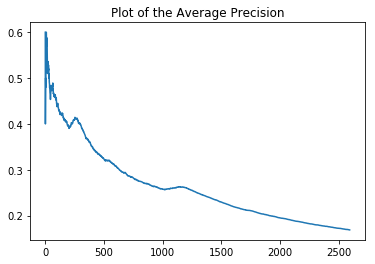

In [36]:
plt.figure()
X_ADO = [x for x in range(len(precisions_ADO))]
plt.plot(X_ADO,precisions_ADO)
plt.title('Plot of the Average Precision')
plt.show()

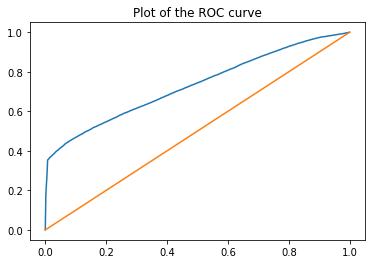

In [37]:
plt.figure()
plt.plot(fp_rates_ADO, recalls_ADO, fp_rates_ADO,fp_rates_ADO )
plt.title('Plot of the ROC curve')
plt.show()

In [38]:
AUROC(fp_rates_ADO, recalls_ADO)

0.7308654583881405

In [39]:
MAP_ADO

0.2054541700962796

### Fourth dataset: MISERABLES

In [40]:
# Importation of the dataset: MISERABLES
# http://konect.uni-koblenz.de/networks/moreno_lesmis

MIS = []
with open('moreno_lesmis\out.moreno_lesmis_lesmis') as inputfile:
    for line in inputfile:
        MIS.append(line.strip().split(','))
MIS = MIS[2:] # list of all the edges
random.shuffle(MIS) # we randomly shuffle the edges

# test size
num_edges_MIS = len(MIS)
num_vertices_MIS = 77
test_size_MIS = int(num_edges_MIS/5)

# Contains the 5 parts forming the whole dataset
parts_MIS = []

start = 0
end = test_size_MIS
for part in range(5):  # We create the 5 parts
    if end>num_edges_MIS:
        parts_MIS.append(MIS[start:])
    else:parts_MIS.append(MIS[start:end])
    start = end
    end = start + test_size_MIS

In [41]:
MIS_G = nx.Graph()
for edge in range(len(MIS)):
    nodes = MIS[edge][0].split(' ')
    MIS_G.add_edge(int(nodes[0]), int(nodes[1]), weight=float(nodes[2]))
MIS_nodes = MIS_G.nodes()

In [42]:
# graphs contains the 5 different training networks 
# targets contains the target links corresponding

MIS_graphs = []
MIS_targets = []

for i in range(5):     # i is the index of the folder we won't use
    G = nx.Graph()
    G.add_nodes_from(MIS_nodes)
    target_links = [] 
    for j in range(5): # We use every other folder
        data = parts_MIS[j]
        if j!=i:        
            for edge in range(len(data)):
                nodes = data[edge][0].split(' ')
                G.add_edge(int(nodes[0]), int(nodes[1]), weight=float(nodes[2])) 
                
                
        else:
            for edge in range(len(data)):
                nodes = data[edge][0].split(' ')
                # For undirected network, we write the min node first
                target_links.append([min(int(nodes[0]),int(nodes[1])),max(int(nodes[0]),int(nodes[1]))])
                
                

    MIS_graphs.append(G)
    MIS_targets.append(target_links)

In [43]:
precisions_MIS, MAP_MIS, recalls_MIS, fp_rates_MIS = CV_results(MIS_graphs,MIS_targets)

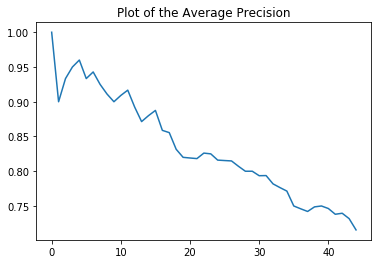

In [44]:
plt.figure()
X_MIS = [x for x in range(len(precisions_MIS))]
plt.plot(X_MIS,precisions_MIS)
plt.title('Plot of the Average Precision')
plt.show()

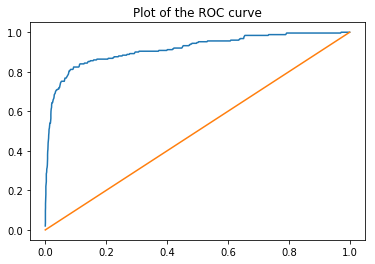

In [45]:
plt.figure()
plt.plot(fp_rates_MIS, recalls_MIS, fp_rates_MIS,fp_rates_MIS )
plt.title('Plot of the ROC curve')
plt.show()

In [46]:
AUROC(fp_rates_MIS, recalls_MIS)

0.9157697196261682

In [47]:
MAP_MIS

0.8474589389678554